# DATA

In [1]:
import numpy as np
import re
import string
import unicodedata
from unicodedata import normalize
import sys
import indicnlp
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.utils import plot_model
import numpy as np
import gensim
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec

In [2]:
def load_doc(filename):
    file = open('hindi-visual-genome-train.txt' , mode ='rt' , encoding = 'utf-8')
    text = file.read()
    file.close()
    return text

In [3]:
def to_pairs(text):
    lines = text.strip().split('\n') #1d list of strings
    eng_hin_pairs = [line.split('\t') for line in lines] #list
    eng_hin_pairs = np.delete(eng_hin_pairs , [0,1,2,3,4] , axis = 1)
#     eng_hin_pairs = np.delete(eng_hin_pairs , 0 , axis = 1)
    eng_hin_pairs = eng_hin_pairs.tolist()
    return eng_hin_pairs    

In [4]:
doc = load_doc('ENG_HIN_SMALL_DATASET.txt')
hin_eng_pairs = to_pairs(doc)
english_sentences = []
hindi_sentences = []
for i in range(len(hin_eng_pairs)):
    english_sentences.append(hin_eng_pairs[i][0])
    hindi_sentences.append(hin_eng_pairs[i][1])

In [5]:
hin_eng_pairs

[['it is an indoor scene', 'यह एक इनडोर दृश्य है'],
 ['Computer screens turned on', 'कंप्यूटर स्क्रीन चालू'],
 ['man has short hair', 'आदमी के छोटे बाल हैं'],
 ["photo album open on an adult's lap", 'एक वयस्क की गोद में फोटो एल्बम खुला'],
 ['there is a group of girls beside the black car',
  'काली कार के पास लड़कियों का एक समूह है'],
 ['Child in a stroller', 'एक घुमक्कड़ में बच्चा'],
 ['Tall metal lightpost', 'लंबा धातु प्रकाश पोस्ट'],
 ['wall is painted white', 'दीवार सफेद रंग की है'],
 ['there are several pictures on the wall', 'दीवार पर कई चित्र हैं'],
 ['woman facing the ocean', 'सागर का सामना कर रही महिला'],
 ['this is an office layout', 'यह एक कार्यालय लेआउट है'],
 ['four metallic chairs', 'चार धातु की कुर्सियाँ'],
 ['Clutter is on a table', 'क्लटर एक मेज पर है'],
 ['a white microwave oven', 'एक सफेद माइक्रोवेव ओवन'],
 ['White SUV driving through intersection',
  'चौराहे के माध्यम से सफेद एसयूवी ड्राइविंग'],
 ['Person crossing street with umbrella', 'छतरी के साथ सड़क पार करते व्य

### Cleaning english data


In [6]:
def clean_english_data(lines):
    re_print = re.compile('[^%s]' %re.escape(string.printable))
    table = str.maketrans('' , '' , string.punctuation)
    clean_english_lines = []
    for line in lines:
        line = normalize('NFD' , line).encode('ascii' , 'ignore')
        line = line.decode('UTF-8')
        line = line.split()
        line = [word.lower() for word in line]
        line = [word.translate(table) for word in line]
        line = [re_print.sub('' , w) for w in line]
        line = [word for word in line if word.isalpha()]
        line = ' '.join(line)
        clean_english_lines.append(line)
    return clean_english_lines    

In [7]:
clean_english_lines = clean_english_data(english_sentences)
print(type(clean_english_lines))
print(english_sentences[0:10])
print(clean_english_lines[0:10])

<class 'list'>
['it is an indoor scene', 'Computer screens turned on', 'man has short hair', "photo album open on an adult's lap", 'there is a group of girls beside the black car', 'Child in a stroller', 'Tall metal lightpost', 'wall is painted white', 'there are several pictures on the wall', 'woman facing the ocean']
['it is an indoor scene', 'computer screens turned on', 'man has short hair', 'photo album open on an adults lap', 'there is a group of girls beside the black car', 'child in a stroller', 'tall metal lightpost', 'wall is painted white', 'there are several pictures on the wall', 'woman facing the ocean']


### Clean hindi data

###### SETTING UP PATHS FOR INDIC NLP

In [8]:
INDIC_NLP_LIB_HOME=r"C:\Users\sudha\Desktop\ALL_PROJECTS\NMT_PROJECTS\Language_Translation_Chat_Bot\LSTM_MODELS\FastText_large_dataset\anoopkunchukuttan-indic_nlp_library-eccde81"
INDIC_NLP_RESOURCES=r"C:\Users\sudha\Desktop\ALL_PROJECTS\NMT_PROJECTS\Language_Translation_Chat_Bot\LSTM_MODELS\FastText_large_dataset\indic_nlp_resources-master"
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp import loader
loader.load()
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from indicnlp.tokenize import indic_tokenize

In [9]:
def clean_text(line):
    text = line
    text = text.replace(u',' ,'')
    text = text.replace(u'"' ,'')
    text = text.replace(u'(' ,'')
    text = text.replace(u')' ,'')
    text = text.replace(u'"' ,'')
    text = text.replace(u':' ,'')
    text = text.replace(u"'" ,'')
    text = text.replace(u"'" ,'')
    text=text.replace(u"‘‘",'')
    text=text.replace(u"’’",'')
    text=text.replace(u"''",'')
    text=text.replace(u".",'')
    text=text.replace(u"-",'')
    text=text.replace(u"।",'')
    text=text.replace(u"?",'')
    text=text.replace(u"\\",'')
    text=text.replace(u"_",'')
    text = re.sub('[a-zA-Z]' , '' , text)
    text = re.sub('[0-9+\-*/.%&!]' , '' , text)
    return text

In [10]:
def clean_hindi_data(lines):
    clean_hin_lines = []
    for line in lines:
        remove_nuktas = False
        factory = IndicNormalizerFactory()
        normalizer = factory.get_normalizer("hi" , remove_nuktas = True )
        line = clean_text(line)
        tokens = list()
        for t in indic_tokenize.trivial_tokenize(line):
            tokens.append(t)
        line = tokens
        line = [ word.lower() for word in line]
        line = [word for word in line if not re.search(r'\d', word)]
        line = ' '.join(line)
        clean_hin_lines.append(line)
    return clean_hin_lines    

In [11]:
clean_hindi_lines = clean_hindi_data(hindi_sentences)
print(hindi_sentences[133])
print(clean_hindi_lines[133])

तार से जुड़ा तार
तार से जुड़ा तार


In [12]:
clean_hindi_lines

['यह एक इनडोर दृश्य है',
 'कंप्यूटर स्क्रीन चालू',
 'आदमी के छोटे बाल हैं',
 'एक वयस्क की गोद में फोटो एल्बम खुला',
 'काली कार के पास लड़कियों का एक समूह है',
 'एक घुमक्कड़ में बच्चा',
 'लंबा धातु प्रकाश पोस्ट',
 'दीवार सफेद रंग की है',
 'दीवार पर कई चित्र हैं',
 'सागर का सामना कर रही महिला',
 'यह एक कार्यालय लेआउट है',
 'चार धातु की कुर्सियाँ',
 'क्लटर एक मेज पर है',
 'एक सफेद माइक्रोवेव ओवन',
 'चौराहे के माध्यम से सफेद एसयूवी ड्राइविंग',
 'छतरी के साथ सड़क पार करते व्यक्ति',
 'इमारत पर झुकाव में आदमी ग्रे पैंट में',
 'भवन पर खिड़की',
 'कारों के बीच में खड़ा एक आदमी',
 'दीवार पर चित्रकला',
 'कुर्सी का पैर',
 'एक नाव की खिड़की',
 'कैबिनेट लकड़ी है',
 'एक आदमी एक किताब पढ़ रहा है',
 'पानी में तैरता हुआ व्यक्ति',
 'चमकती छाया के साथ दीपक',
 'प्लेट पर फल',
 'एक चीनी मिट्टी के बरतन सफ़ेद प्लेट',
 'काला खेल नियंत्रक',
 'कार की डिक्की में कुछ डालने वाला व्यक्ति',
 'एक सड़क के साथ ग्रीन कार पार्क किया',
 'गली पर कार',
 'निर्माण कर्मचारी कवरलेस पहनते हैं',
 'पीले दरवाजे के साथ एक काली कार',
 'म

In [13]:
clean_english_lines

['it is an indoor scene',
 'computer screens turned on',
 'man has short hair',
 'photo album open on an adults lap',
 'there is a group of girls beside the black car',
 'child in a stroller',
 'tall metal lightpost',
 'wall is painted white',
 'there are several pictures on the wall',
 'woman facing the ocean',
 'this is an office layout',
 'four metallic chairs',
 'clutter is on a table',
 'a white microwave oven',
 'white suv driving through intersection',
 'person crossing street with umbrella',
 'man in gray pants leaning on building',
 'window on the building',
 'a man standing in between cars',
 'painting hanging on wall',
 'leg of the chair',
 'window of a boat',
 'the cabinet is wood',
 'a man reading a book',
 'a person swimming in water',
 'lamp with glowing shade',
 'fruit on the plate',
 'a porcelain white plate',
 'black game controller',
 'a person putting something in the trunk of the car',
 'green car parked along a street',
 'car on the street',
 'construction worker 

In [14]:
clean_eng_lines = [line.split() for line in clean_english_lines]
# sentences = [[word for word in document.split()] for document in popular_titles]

In [15]:
clean_eng_lines

[['it', 'is', 'an', 'indoor', 'scene'],
 ['computer', 'screens', 'turned', 'on'],
 ['man', 'has', 'short', 'hair'],
 ['photo', 'album', 'open', 'on', 'an', 'adults', 'lap'],
 ['there', 'is', 'a', 'group', 'of', 'girls', 'beside', 'the', 'black', 'car'],
 ['child', 'in', 'a', 'stroller'],
 ['tall', 'metal', 'lightpost'],
 ['wall', 'is', 'painted', 'white'],
 ['there', 'are', 'several', 'pictures', 'on', 'the', 'wall'],
 ['woman', 'facing', 'the', 'ocean'],
 ['this', 'is', 'an', 'office', 'layout'],
 ['four', 'metallic', 'chairs'],
 ['clutter', 'is', 'on', 'a', 'table'],
 ['a', 'white', 'microwave', 'oven'],
 ['white', 'suv', 'driving', 'through', 'intersection'],
 ['person', 'crossing', 'street', 'with', 'umbrella'],
 ['man', 'in', 'gray', 'pants', 'leaning', 'on', 'building'],
 ['window', 'on', 'the', 'building'],
 ['a', 'man', 'standing', 'in', 'between', 'cars'],
 ['painting', 'hanging', 'on', 'wall'],
 ['leg', 'of', 'the', 'chair'],
 ['window', 'of', 'a', 'boat'],
 ['the', 'cabinet'

In [16]:
clean_hin_lines = [line.split() for line in clean_hindi_lines]

In [17]:
clean_hin_lines

[['यह', 'एक', 'इनडोर', 'दृश्य', 'है'],
 ['कंप्यूटर', 'स्क्रीन', 'चालू'],
 ['आदमी', 'के', 'छोटे', 'बाल', 'हैं'],
 ['एक', 'वयस्क', 'की', 'गोद', 'में', 'फोटो', 'एल्बम', 'खुला'],
 ['काली', 'कार', 'के', 'पास', 'लड़कियों', 'का', 'एक', 'समूह', 'है'],
 ['एक', 'घुमक्कड़', 'में', 'बच्चा'],
 ['लंबा', 'धातु', 'प्रकाश', 'पोस्ट'],
 ['दीवार', 'सफेद', 'रंग', 'की', 'है'],
 ['दीवार', 'पर', 'कई', 'चित्र', 'हैं'],
 ['सागर', 'का', 'सामना', 'कर', 'रही', 'महिला'],
 ['यह', 'एक', 'कार्यालय', 'लेआउट', 'है'],
 ['चार', 'धातु', 'की', 'कुर्सियाँ'],
 ['क्लटर', 'एक', 'मेज', 'पर', 'है'],
 ['एक', 'सफेद', 'माइक्रोवेव', 'ओवन'],
 ['चौराहे', 'के', 'माध्यम', 'से', 'सफेद', 'एसयूवी', 'ड्राइविंग'],
 ['छतरी', 'के', 'साथ', 'सड़क', 'पार', 'करते', 'व्यक्ति'],
 ['इमारत', 'पर', 'झुकाव', 'में', 'आदमी', 'ग्रे', 'पैंट', 'में'],
 ['भवन', 'पर', 'खिड़की'],
 ['कारों', 'के', 'बीच', 'में', 'खड़ा', 'एक', 'आदमी'],
 ['दीवार', 'पर', 'चित्रकला'],
 ['कुर्सी', 'का', 'पैर'],
 ['एक', 'नाव', 'की', 'खिड़की'],
 ['कैबिनेट', 'लकड़ी', 'है'],
 ['एक', 'आदमी'

### Adding SOS and EOS ,  PREPARING INPUTS FOR ENCODER AND DECODER

In [18]:
num_sentences = 2200 #(about 80-20 ratio)
input_sentences = []
output_sentences = []
output_sentences_inputs = []
#input sentences
input_sentences = clean_english_lines[0:num_sentences]

#output sentences
for line in clean_hindi_lines[0:num_sentences]:
    line = line + ' <eos>'
    output_sentences.append(line)

#output sentence input

for line in clean_hindi_lines[0:num_sentences]:
    line = '<sos> ' + line
    output_sentences_inputs.append(line)
    
len(input_sentences)
output_sentences_inputs[0:10]
print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))
print(len(output_sentences + output_sentences_inputs))

num samples input: 2200
num samples output: 2200
num samples output input: 2200
4400


In [19]:
input_sentences

['it is an indoor scene',
 'computer screens turned on',
 'man has short hair',
 'photo album open on an adults lap',
 'there is a group of girls beside the black car',
 'child in a stroller',
 'tall metal lightpost',
 'wall is painted white',
 'there are several pictures on the wall',
 'woman facing the ocean',
 'this is an office layout',
 'four metallic chairs',
 'clutter is on a table',
 'a white microwave oven',
 'white suv driving through intersection',
 'person crossing street with umbrella',
 'man in gray pants leaning on building',
 'window on the building',
 'a man standing in between cars',
 'painting hanging on wall',
 'leg of the chair',
 'window of a boat',
 'the cabinet is wood',
 'a man reading a book',
 'a person swimming in water',
 'lamp with glowing shade',
 'fruit on the plate',
 'a porcelain white plate',
 'black game controller',
 'a person putting something in the trunk of the car',
 'green car parked along a street',
 'car on the street',
 'construction worker 

### creating the word2vec embedding:
Parameters: - sentences : The sentences we have obtained.

size : The dimesnions of the vector used to represent each word.

window : The number f words around any word to see the context.

min_count : The minimum number of times a word should appear for its embedding to be formed or learnt.

In [20]:
# Defining values for parameters
embedding_size = 100
window_size = 5
min_word = 5
down_sampling = 1e-2

fast_text_model = FastText(clean_eng_lines, 
                           vector_size = embedding_size,
                           window = window_size,
                           min_count = min_word,
                           sample = down_sampling,
                           workers = 4,
                           sg = 1,
                           epochs =100)

#### save and load the FatsText model

In [21]:
fast_text_model.save("FT_model")
#load saved gensim fastext model
fast_text_model = Word2Vec.load("FT_model")

In [22]:
fast_text_model.wv['book']

array([-0.7334351 ,  0.41504887, -0.49858588,  0.8474882 , -0.6105335 ,
        0.14312492, -0.3419928 ,  0.22583608,  0.8897784 ,  0.06112357,
        0.23432474, -0.779837  ,  0.16135903,  1.0539876 , -0.13310796,
        0.5049324 , -0.2392698 ,  0.428514  , -0.8261184 , -0.5343926 ,
        0.37516364, -0.7228089 ,  0.28895652,  0.05384233, -0.01581865,
       -0.09763801, -0.01463841, -0.01948437, -0.6765831 , -0.02554048,
       -0.07288597,  0.8061491 ,  0.38036916, -0.2444934 , -0.64783823,
        0.51056314,  0.5282305 , -0.10243123,  0.18692428, -0.0718186 ,
       -0.6893857 ,  0.0901269 , -1.3345368 , -0.6794913 ,  0.603719  ,
        0.712578  , -0.59118456,  0.08676216, -0.18548422, -0.470963  ,
        0.2151031 ,  0.29413807, -0.6882511 , -0.45911568,  0.30362284,
       -0.9098845 , -0.34939152, -0.7283777 ,  0.17279106,  0.3406864 ,
       -0.83952427,  0.2761935 ,  0.1380093 , -0.54465497,  0.5424275 ,
        0.19136971, -0.29120034, -0.20924464, -0.59449047, -0.98

In [23]:
# vocab = list(w2v_model.wv.index_to_key)
wv = fast_text_model.wv
vocab = list(fast_text_model.wv.index_to_key)
keys = fast_text_model.wv.key_to_index

In [24]:
vocab


['a',
 'the',
 'on',
 'of',
 'is',
 'in',
 'white',
 'man',
 'and',
 'black',
 'with',
 'red',
 'blue',
 'this',
 'woman',
 'green',
 'brown',
 'person',
 'two',
 'wearing',
 'yellow',
 'sign',
 'train',
 'sky',
 'wall',
 'water',
 'are',
 'building',
 'an',
 'table',
 'people',
 'standing',
 'street',
 'large',
 'tennis',
 'head',
 'sitting',
 'part',
 'clock',
 'bus',
 'dog',
 'small',
 'light',
 'plate',
 'holding',
 'to',
 'cat',
 'grass',
 'shirt',
 'window',
 'has',
 'at',
 'orange',
 'side',
 'ground',
 'plane',
 'bear',
 'boy',
 'car',
 'giraffe',
 'top',
 'girl',
 'playing',
 'road',
 'snow',
 'baseball',
 'field',
 'horse',
 'bench',
 'air',
 'silver',
 'elephant',
 'pizza',
 'front',
 'walking',
 'tree',
 'zebra',
 'toilet',
 'hair',
 'bird',
 'riding',
 'down',
 'umbrella',
 'three',
 'skateboard',
 'truck',
 'picture',
 'player',
 'wooden',
 'hat',
 'parked',
 'pole',
 'ball',
 'frisbee',
 'boat',
 'gray',
 'pink',
 'motorcycle',
 'bed',
 'kite',
 'glass',
 'food',
 'flyin

In [25]:
keys

{'a': 0,
 'the': 1,
 'on': 2,
 'of': 3,
 'is': 4,
 'in': 5,
 'white': 6,
 'man': 7,
 'and': 8,
 'black': 9,
 'with': 10,
 'red': 11,
 'blue': 12,
 'this': 13,
 'woman': 14,
 'green': 15,
 'brown': 16,
 'person': 17,
 'two': 18,
 'wearing': 19,
 'yellow': 20,
 'sign': 21,
 'train': 22,
 'sky': 23,
 'wall': 24,
 'water': 25,
 'are': 26,
 'building': 27,
 'an': 28,
 'table': 29,
 'people': 30,
 'standing': 31,
 'street': 32,
 'large': 33,
 'tennis': 34,
 'head': 35,
 'sitting': 36,
 'part': 37,
 'clock': 38,
 'bus': 39,
 'dog': 40,
 'small': 41,
 'light': 42,
 'plate': 43,
 'holding': 44,
 'to': 45,
 'cat': 46,
 'grass': 47,
 'shirt': 48,
 'window': 49,
 'has': 50,
 'at': 51,
 'orange': 52,
 'side': 53,
 'ground': 54,
 'plane': 55,
 'bear': 56,
 'boy': 57,
 'car': 58,
 'giraffe': 59,
 'top': 60,
 'girl': 61,
 'playing': 62,
 'road': 63,
 'snow': 64,
 'baseball': 65,
 'field': 66,
 'horse': 67,
 'bench': 68,
 'air': 69,
 'silver': 70,
 'elephant': 71,
 'pizza': 72,
 'front': 73,
 'walking'

In [26]:
fast_text_model.wv.get_vector('book')

array([-0.7334351 ,  0.41504887, -0.49858588,  0.8474882 , -0.6105335 ,
        0.14312492, -0.3419928 ,  0.22583608,  0.8897784 ,  0.06112357,
        0.23432474, -0.779837  ,  0.16135903,  1.0539876 , -0.13310796,
        0.5049324 , -0.2392698 ,  0.428514  , -0.8261184 , -0.5343926 ,
        0.37516364, -0.7228089 ,  0.28895652,  0.05384233, -0.01581865,
       -0.09763801, -0.01463841, -0.01948437, -0.6765831 , -0.02554048,
       -0.07288597,  0.8061491 ,  0.38036916, -0.2444934 , -0.64783823,
        0.51056314,  0.5282305 , -0.10243123,  0.18692428, -0.0718186 ,
       -0.6893857 ,  0.0901269 , -1.3345368 , -0.6794913 ,  0.603719  ,
        0.712578  , -0.59118456,  0.08676216, -0.18548422, -0.470963  ,
        0.2151031 ,  0.29413807, -0.6882511 , -0.45911568,  0.30362284,
       -0.9098845 , -0.34939152, -0.7283777 ,  0.17279106,  0.3406864 ,
       -0.83952427,  0.2761935 ,  0.1380093 , -0.54465497,  0.5424275 ,
        0.19136971, -0.29120034, -0.20924464, -0.59449047, -0.98

#### Tokenizing and padding  english and hindi

In [27]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

In [28]:
# for vocabulary

In [29]:
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<sos>'] = 0
#     self.word2idx['<eos>'] = 1
    
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word


In [30]:
pairs = []
for i in range(len(input_sentences)):
    pairs.append([])
    pairs[i].append(input_sentences[i])
    pairs[i].append(output_sentences_inputs[i])
    pairs[i].append(output_sentences[i])



In [31]:
output_sentences_inputs[0:10]

['<sos> यह एक इनडोर दृश्य है',
 '<sos> कंप्यूटर स्क्रीन चालू',
 '<sos> आदमी के छोटे बाल हैं',
 '<sos> एक वयस्क की गोद में फोटो एल्बम खुला',
 '<sos> काली कार के पास लड़कियों का एक समूह है',
 '<sos> एक घुमक्कड़ में बच्चा',
 '<sos> लंबा धातु प्रकाश पोस्ट',
 '<sos> दीवार सफेद रंग की है',
 '<sos> दीवार पर कई चित्र हैं',
 '<sos> सागर का सामना कर रही महिला']

In [32]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def load_dataset(pairs):  
    inp_lang = LanguageIndex(en for en, hi,hi2 in pairs)
    targ_lang= LanguageIndex(hi for en, hi,hi2 in pairs)
#   targ_lang_decoder_output: hindi sentences with <eos>
    targ_lang = LanguageIndex(hi2 for en, hi, hi2 in pairs)
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, hi, hi2 in pairs]
    target_tensor = [[targ_lang.word2idx[s] for s in hi.split(' ')] for en, hi, hi2 in pairs]
    target_tensor_decoder_output = [[targ_lang.word2idx[s] for s in hi2.split(' ')] for en, hi, hi2 in pairs]
    max_length_inp, max_length_targ, max_length_target_decoder_output = max_length(input_tensor), max_length(target_tensor) , max_length(target_tensor_decoder_output)
    input_lang_vocab = inp_lang.vocab
    return inp_lang, targ_lang,max_length_inp, max_length_targ,max_length_target_decoder_output, input_tensor, target_tensor, target_tensor_decoder_output, input_lang_vocab




In [33]:
inp_lang, targ_lang,max_length_inp, max_length_targ,max_length_target_decoder_output, input_tensor, target_tensor, target_tensor_decoder_output, input_lang_vocab= load_dataset(pairs)
# print(targ_lang_decoder_output.word2idx)
input_lang_word2idx = inp_lang.word2idx
word2idx_outputs = targ_lang.word2idx
num_words_output = len(word2idx_outputs) + 1
input_lang_vocab = inp_lang.vocab
# input_lang_vocab
input_tensor

[[586, 585, 25, 579, 969],
 [273, 974, 1261, 772],
 [687, 531, 1013, 520],
 [835, 17, 776, 772, 25, 4, 620],
 [1195, 585, 1, 513, 766, 491, 108, 1191, 120, 196],
 [229, 578, 1, 1139],
 [1175, 702, 650],
 [1305, 585, 799, 1325],
 [1195, 40, 988, 840, 772, 1191, 1305],
 [1341, 421, 1191, 765],
 [1199, 585, 25, 768, 627],
 [466, 703, 220],
 [255, 585, 772, 1, 1166],
 [1, 1325, 706, 788],
 [1325, 1158, 385, 1201, 583],
 [832, 307, 1134, 1339, 1266],
 [687, 578, 508, 807, 631, 772, 164],
 [1331, 772, 1191, 164],
 [1, 687, 1110, 578, 109, 204],
 [800, 527, 772, 1305],
 [637, 766, 1191, 219],
 [1331, 766, 1, 133],
 [1191, 181, 585, 1345],
 [1, 687, 915, 1, 136],
 [1, 832, 1161, 578, 1312],
 [616, 1339, 496, 990],
 [477, 772, 1191, 863],
 [1, 876, 1325, 863],
 [120, 481, 284],
 [1, 832, 899, 1081, 578, 1191, 1256, 766, 1191, 196],
 [509, 196, 813, 19, 1, 1134],
 [196, 772, 1191, 1134],
 [281, 1351, 1317, 299],
 [1, 120, 196, 1339, 1, 1356, 368],
 [219, 51, 1191, 1166],
 [1, 747, 778, 772, 1, 2

In [34]:
# padding

In [35]:
def padded_tensor(max_length_inp, max_length_targ, input_tensor , target_tensor, target_tensor_decoder_output):
    
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='pre')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_targ, padding='post')
    encoder_input_sequences = pad_sequences(input_tensor, maxlen=max_length_inp,padding='pre')
    decoder_input_sequences = pad_sequences(target_tensor, maxlen=max_length_targ, padding='post')
    target_tensor_decoder_output = pad_sequences(target_tensor_decoder_output, maxlen=max_length_target_decoder_output, padding='post')
    return input_tensor, target_tensor, target_tensor_decoder_output, encoder_input_sequences , decoder_input_sequences


In [36]:
input_tensor_train, target_tensor_train,target_tensor_decoder_output_train, encoder_input_sequences , decoder_input_sequences = padded_tensor(max_length_inp, max_length_targ, input_tensor , target_tensor, target_tensor_decoder_output)

In [37]:
input_tensor_train

array([[   0,    0,    0, ...,   25,  579,  969],
       [   0,    0,    0, ...,  974, 1261,  772],
       [   0,    0,    0, ...,  531, 1013,  520],
       ...,
       [   0,    0,    0, ...,  830, 1302,   45],
       [   0,    0,    0, ..., 1039,  772,  726],
       [   0,    0,    0, ..., 1317,  874, 1290]])

In [38]:
target_tensor_train

array([[   0, 1191,  115, ...,    0,    0,    0],
       [   0,  140, 1516, ...,    0,    0,    0],
       [   0,   52,  243, ...,    0,    0,    0],
       ...,
       [   0,   39, 1311, ...,    0,    0,    0],
       [   0, 1184,  811, ...,    0,    0,    0],
       [   0,   52,  881, ...,    0,    0,    0]])

### word embeddings

In [39]:
vocab = input_lang_vocab
print(len(vocab))
FT_dict = {}
for word in vocab:
    FT_dict[word] = fast_text_model.wv.get_vector(word)
    
print("the no of key-value pairs:"  , len(FT_dict))
FT_dict

1362
the no of key-value pairs: 1362


{'a': array([ 0.1416527 ,  0.23542295,  0.01961737,  0.18754292, -0.00959925,
        -0.01711554,  0.10063657,  0.07971822, -0.00262874, -0.05068549,
        -0.08663099, -0.07492594, -0.00377013,  0.03909098, -0.00986792,
        -0.0043999 , -0.02939004, -0.01122249,  0.1706081 , -0.01287068,
        -0.07684235, -0.22986367,  0.17648062,  0.06990125,  0.07655609,
        -0.00304851, -0.13182518,  0.04085071, -0.16663392, -0.04346224,
        -0.01644768,  0.0483855 ,  0.01778344, -0.01440959,  0.13258563,
        -0.15252358, -0.01947493,  0.08689055, -0.05263081,  0.09476356,
        -0.06664754, -0.01060834,  0.0144758 , -0.07774991,  0.00646102,
         0.0054958 , -0.03913901, -0.02637817,  0.00571872,  0.0063846 ,
         0.0303195 , -0.0765145 ,  0.1454692 , -0.011881  ,  0.01919587,
        -0.08308174, -0.06642893, -0.08072062, -0.0886944 , -0.13208139,
         0.105461  , -0.05276943,  0.02807916,  0.07538607, -0.07845397,
         0.07535982,  0.03204579,  0.15683645,

The dictionary embeddings_dictionary now contains words and corresponding GloVe embeddings for all the words.

We want the word embeddings for only those words that are present in our corpus. We will create a two dimensional numpy array of 44 (size of vocabulary) rows and 100 columns. The array will initially contain zeros. The array will be named as embedding_matrix

Next, we will iterate through each word in our corpus by traversing the word_tokenizer.word_index dictionary that contains our words and their corresponding index.

Each word will be passed as key to the embedding_dictionary to retrieve the corresponding 100 dimensional vector for the word. The 100 dimensional vector will then be stored at the corresponding index of the word in the embedding_matrix. Look at the following script:

In [40]:
num_words = min(MAX_NUM_WORDS, len(input_lang_vocab) + 1)
# embedding_matrix = zeros((len(input_lang_vocab)+1, 100))
# for word, index in input_lang_word2idx.items(): #input_lang_word2idx=1847
#     embedding_vector = embeddings_dictionary.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[index] = embedding_vector
        
# creating the embedding matrix
embedding_matrix = np.zeros(shape= (len(input_lang_vocab)+1 , 100))
for word,i in input_lang_word2idx.items():
    embedding_vector = FT_dict.get(word)
    if embedding_vector is not None:   # word is in the vocabulary learned by the w2v model
        embedding_matrix[i]=embedding_vector
     # if word is not found then embed_vector corressponding to that vector will stay zero.


In [41]:
embedding_matrix.shape

(1363, 100)

In [42]:
# creating the embedding layer

In [43]:
embedding_layer = Embedding(num_words , EMBEDDING_SIZE , weights = [embedding_matrix] , input_length = max_length_inp)


In [44]:
num_words

1363

In [45]:
embedding_matrix.shape

(1363, 100)

In [46]:
max_length_inp

11

# MODEL

## CREATING THE MODEL

In [47]:
decoder_targets_one_hot = np.zeros((len(input_sentences) , max_length_targ , num_words_output), dtype = 'float32')


In [48]:
decoder_targets_one_hot.shape

(2200, 15, 1616)

In [49]:
type(decoder_targets_one_hot)

numpy.ndarray

In [50]:
for i, d in enumerate(target_tensor_decoder_output_train):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [51]:
print(decoder_targets_one_hot[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## create the encoder and decoders

In [52]:
encoder_inputs_placeholder = Input(shape = (max_length_inp,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state = True)
encoder_outputs, h ,c = encoder(x)
encoder_states = [h,c]

In [53]:
decoder_inputs_placeholder = Input(shape= (max_length_targ,))

decoder_embedding = Embedding(num_words_output , LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LSTM_NODES , return_sequences = True , return_state = True)

decoder_outputs , _ , _ = decoder_lstm(decoder_inputs_x , initial_state = encoder_states)


In [54]:
decoder_dense= Dense(num_words_output , activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)


## compile the model:

In [55]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder] , decoder_outputs)

model.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


## plotting the model

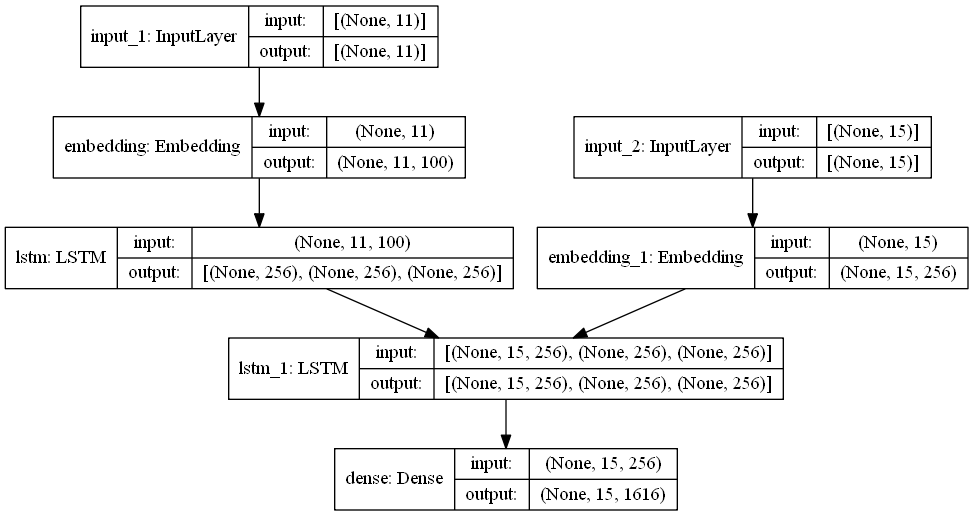

In [56]:
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

## fitting the model

In [57]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_split=0.1,
)

Epoch 1/100
31/31 [==============================] - 4s 38ms/step - loss: 2.8444 - accuracy: 0.5953 - val_loss: 2.2815 - val_accuracy: 0.6230
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 2.0693 - accuracy: 0.6493 - val_loss: 2.1443 - val_accuracy: 0.6794
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 1.9043 - accuracy: 0.6912 - val_loss: 2.0815 - val_accuracy: 0.6867
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 1.7788 - accuracy: 0.7043 - val_loss: 1.9980 - val_accuracy: 0.6964
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 1.6508 - accuracy: 0.7225 - val_loss: 1.9388 - val_accuracy: 0.7121
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 1.5233 - accuracy: 0.7398 - val_loss: 1.9077 - val_accuracy: 0.7203
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 1.4108 - accuracy: 0.7530 - val_loss: 1.8140 - val_accuracy: 0.7309
Epoch 

31/31 [==============================] - 0s 15ms/step - loss: 0.0096 - accuracy: 0.9964 - val_loss: 1.7687 - val_accuracy: 0.7891
Epoch 59/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0097 - accuracy: 0.9963 - val_loss: 1.7754 - val_accuracy: 0.7879
Epoch 60/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0093 - accuracy: 0.9964 - val_loss: 1.7804 - val_accuracy: 0.7882
Epoch 61/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0096 - accuracy: 0.9966 - val_loss: 1.8041 - val_accuracy: 0.7924
Epoch 62/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0100 - accuracy: 0.9964 - val_loss: 1.7989 - val_accuracy: 0.7879
Epoch 63/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0093 - accuracy: 0.9963 - val_loss: 1.8129 - val_accuracy: 0.7852
Epoch 64/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0085 - accuracy: 0.9963 - val_loss: 1.8078 - val_accuracy: 0.7903
Epoch 65/100